# Imports

In [35]:
import tensorflow as tf
import numpy as np
import progressbar
import matplotlib.pyplot as plt
import time
import pickle as pkl
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


For a Generative Adversarial Network we need two networks, one generative and one discriminative.  

# Generator

The generator network takes a latent vector z as input which it is supposed to map to a handwritten digit. In general it's a universal function approximator. We use a leaky ReLU activation with parameter alpha (defines the magnitude of the output for negative values) to allow gradients to flow backwards through the layer unimpeded. 

In [57]:
def generator(generator_input, output_dim=784, n_units=128, reuse=False,  alpha=0.01):    
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer 1
        layer1 = tf.layers.dense(generator_input, n_units, activation=None)
        # Leaky ReLU
        layer1 = tf.maximum(layer1, alpha*layer1)
        
        # Logits and tanh output
        logits = tf.layers.dense(layer1, output_dim, activation=None)
        out = tf.nn.tanh(logits)
        
        return out, logits

# Discriminator

The discriminator network takes both the real mnist images and the fake images generated from the generator network as input. Hence have to share variables between the fake and real input images. This is done using the reuse keyword for tf.variable_scope (tells TensorFlow to reuse the variables instead of creating new ones if we build the graph again). The output is 1-dimensional where 0 indicates a fake image and 1 indicates an real image.

In [58]:
def discriminator(discriminator_input, output_dim=1, n_units=128, reuse=False,  alpha=0.01):    
    with tf.variable_scope('discriminator', reuse=reuse):        
        # Hidden layer 1
        layer1 = tf.layers.dense(discriminator_input, n_units, activation=None)
        # Leaky ReLU
        layer1 = tf.maximum(layer1, alpha*layer1)
        
        logits = tf.layers.dense(layer1, output_dim, activation=None)
        out = tf.nn.sigmoid(logits)
        
        return out, logits

# Hyperparameters

In [59]:
# Size of input image to discriminator.
input_size = 784 # MNIST images.
z_size = 100 # Latent vector to generator.
# Hidden layers in generator and discriminator.
g_hidden = 128
d_hidden = 128
# Leak factor for ReLU.
alpha = 0.01
# Label smoothing.
smooth = 0.1

# Network

In [60]:
tf.reset_default_graph() 

inputs_real = tf.placeholder(tf.float32, (None, input_size), name="inputs_real") # Mnist input.

latent_z = tf.placeholder(tf.float32, (None, z_size), name="latent_z") # Latent sample as input to generator.

# Generator.
g_model, g_logits = generator(latent_z, n_units=g_hidden, reuse=False,  alpha=alpha)

# Disriminator.
d_model_real, d_logits_real = discriminator(inputs_real, n_units=d_hidden, reuse=False, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, n_units=d_hidden, reuse=True, alpha=alpha) # Use reuse to keep weights.

# Loss

In [61]:
d_labels_real = tf.ones_like(d_logits_real) * (1 - smooth) # Every discriminator label from input real, is real + smoothing.
d_labels_fake = tf.zeros_like(d_logits_fake) # Every discriminator label from generator, is false.

g_loss = tf.reduce_mean( 
    tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(d_logits_fake), 
        logits=d_logits_fake))


d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_real, logits=d_logits_real)
d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_fake, logits=d_logits_fake)
d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)

# Optimize

In [62]:
# Optimizers.
learning_rate = 0.001

# Get the trainable_variables.
all_vars = tf.trainable_variables()
disciminator_vars = [var for var in all_vars if var.name.startswith("discriminator")] # Discriminator weights.
generator_vars = [var for var in all_vars if var.name.startswith("generator")] # Generator weigths.
g_train = tf.train.AdamOptimizer().minimize(g_loss, var_list=generator_vars)
d_train = tf.train.AdamOptimizer().minimize(d_loss, var_list=disciminator_vars) 


# Train

In [53]:
batch_size = 100
epochs = 200
samples = [] # To save samples during training.
saver = tf.train.Saver(var_list = all_vars)
N = mnist.train.num_examples//batch_size

# Progessbar.
widgets = [
    progressbar.Percentage(),
    progressbar.Bar(),
    progressbar.DynamicMessage('Generatorloss'), ' ',
    progressbar.DynamicMessage('Discriminatorloss'), ' ']
bar = progressbar.ProgressBar(widgets=widgets, max_value=N, term_width=100)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    try: 
        saver.restore(sess, tf.train.latest_checkpoint('./checkpoints/')) # Restore if checkpoint exist.
    except:
        pass
    for e in range(epochs):
        # Initialize progressbar
        print('='*20 + " Epoch {}\{} ".format(e+1, epochs) + '='*20)
        time.sleep(0.5)
        bar.update(0, Generatorloss=0, Discriminatorloss=0)
        for i in range(N):
            batch = mnist.train.next_batch(batch_size) # Next mnist batch.
            
            batch_mnist = batch[0].reshape((batch_size, 784)) # Flatten.
            batch_mnist = batch_mnist*2 - 1 # Rescale.
            
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size)) # Random noise for generator.
            
            # Run optimizers.
            _ = sess.run(d_train, feed_dict={inputs_real: batch_mnist, latent_z: batch_z})
            _ = sess.run(g_train, feed_dict={latent_z: batch_z})
            bar.update(i)    
        
        # Update progessbar with losses.
        train_loss_d = sess.run(d_loss, {inputs_real: batch_mnist, latent_z: batch_z})
        train_loss_g = g_loss.eval({latent_z: batch_z})
        time.sleep(0.1)
        bar.update(N, Generatorloss=train_loss_g, Discriminatorloss=train_loss_d)
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(5, z_size))
        generator_img,logits = sess.run(
                       generator(latent_z, reuse=True),
                       feed_dict={latent_z: sample_z})
        img = tf.reshape(generator_img, [-1, 28, 28])
        samples.append(img.eval())
        saver.save(sess, './checkpoints/Mnist_gan.ckpt')

==================== Epoch 1\200 ====================


100%|##############################################|Generatorloss:   3.83 Discriminatorloss:  0.356 

==================== Epoch 2\200 ====================


100%|##############################################|Generatorloss:   3.61 Discriminatorloss:  0.364 

==================== Epoch 3\200 ====================


100%|##############################################|Generatorloss:   3.57 Discriminatorloss:  0.395 

==================== Epoch 4\200 ====================


100%|##############################################|Generatorloss:   3.68 Discriminatorloss:  0.411 

==================== Epoch 5\200 ====================


100%|##############################################|Generatorloss:   4.42 Discriminatorloss:  0.434 

==================== Epoch 6\200 ====================


100%|##############################################|Generatorloss:   3.02 Discriminatorloss:  0.579 

==================== Epoch 7\200 ====================


100%|##############################################|Generatorloss:   2.87 Discriminatorloss:  0.703 

==================== Epoch 8\200 ====================


100%|##############################################|Generatorloss:   2.79 Discriminatorloss:   0.64 

==================== Epoch 9\200 ====================


100%|##############################################|Generatorloss:   2.28 Discriminatorloss:  0.794 

==================== Epoch 10\200 ====================


100%|##############################################|Generatorloss:   2.18 Discriminatorloss:  0.681 

==================== Epoch 11\200 ====================


100%|##############################################|Generatorloss:    2.1 Discriminatorloss:   0.93 

==================== Epoch 12\200 ====================


100%|##############################################|Generatorloss:   3.21 Discriminatorloss:   1.15 

==================== Epoch 13\200 ====================


100%|##############################################|Generatorloss:   1.68 Discriminatorloss:  0.966 

==================== Epoch 14\200 ====================


100%|##############################################|Generatorloss:   1.84 Discriminatorloss:   1.01 

==================== Epoch 15\200 ====================


100%|##############################################|Generatorloss:    2.1 Discriminatorloss:   1.23 

==================== Epoch 16\200 ====================


100%|##############################################|Generatorloss:   3.85 Discriminatorloss:   1.06 

==================== Epoch 17\200 ====================


100%|##############################################|Generatorloss:   2.44 Discriminatorloss:  0.868 

==================== Epoch 18\200 ====================


100%|##############################################|Generatorloss:   1.16 Discriminatorloss:    1.9 

==================== Epoch 19\200 ====================


100%|##############################################|Generatorloss:   2.44 Discriminatorloss:   1.24 

==================== Epoch 20\200 ====================


100%|##############################################|Generatorloss:   1.89 Discriminatorloss:   1.08 

==================== Epoch 21\200 ====================


100%|##############################################|Generatorloss:    1.7 Discriminatorloss:   1.02 

==================== Epoch 22\200 ====================


100%|##############################################|Generatorloss:   1.97 Discriminatorloss:   1.05 

==================== Epoch 23\200 ====================


100%|##############################################|Generatorloss:   2.24 Discriminatorloss:  0.964 

==================== Epoch 24\200 ====================


100%|##############################################|Generatorloss:    1.6 Discriminatorloss:   1.38 

==================== Epoch 25\200 ====================


100%|##############################################|Generatorloss:   1.43 Discriminatorloss:   1.36 

==================== Epoch 26\200 ====================


100%|##############################################|Generatorloss:    2.2 Discriminatorloss:   1.07 

==================== Epoch 27\200 ====================


100%|##############################################|Generatorloss:   1.77 Discriminatorloss:   1.04 

==================== Epoch 28\200 ====================


100%|##############################################|Generatorloss:   1.45 Discriminatorloss:   1.44 

==================== Epoch 29\200 ====================


100%|##############################################|Generatorloss:    1.5 Discriminatorloss:   1.01 

==================== Epoch 30\200 ====================


100%|##############################################|Generatorloss:   2.31 Discriminatorloss:  0.996 

==================== Epoch 31\200 ====================


100%|##############################################|Generatorloss:   1.39 Discriminatorloss:    1.4 

==================== Epoch 32\200 ====================


100%|##############################################|Generatorloss:   2.47 Discriminatorloss:  0.805 

==================== Epoch 33\200 ====================


100%|##############################################|Generatorloss:   1.44 Discriminatorloss:   1.05 

==================== Epoch 34\200 ====================


100%|##############################################|Generatorloss:   1.89 Discriminatorloss:  0.991 

==================== Epoch 35\200 ====================


100%|##############################################|Generatorloss:   1.84 Discriminatorloss:   1.04 

==================== Epoch 36\200 ====================


100%|##############################################|Generatorloss:   1.78 Discriminatorloss:   1.05 

==================== Epoch 37\200 ====================


100%|##############################################|Generatorloss:   1.63 Discriminatorloss:   1.06 

==================== Epoch 38\200 ====================


100%|##############################################|Generatorloss:    1.3 Discriminatorloss:   1.33 

==================== Epoch 39\200 ====================


100%|##############################################|Generatorloss:   1.72 Discriminatorloss:   1.11 

==================== Epoch 40\200 ====================


100%|##############################################|Generatorloss:   1.16 Discriminatorloss:   1.32 

==================== Epoch 41\200 ====================


100%|##############################################|Generatorloss:   1.32 Discriminatorloss:   1.11 

==================== Epoch 42\200 ====================


100%|##############################################|Generatorloss:   1.27 Discriminatorloss:   1.19 

==================== Epoch 43\200 ====================


100%|##############################################|Generatorloss:   1.62 Discriminatorloss:   1.17 

==================== Epoch 44\200 ====================


100%|##############################################|Generatorloss:    1.3 Discriminatorloss:   1.14 

==================== Epoch 45\200 ====================


100%|##############################################|Generatorloss:   1.91 Discriminatorloss:  0.922 

==================== Epoch 46\200 ====================


100%|##############################################|Generatorloss:   1.86 Discriminatorloss:   1.03 

==================== Epoch 47\200 ====================


100%|##############################################|Generatorloss:    1.8 Discriminatorloss:   1.36 

==================== Epoch 48\200 ====================


100%|##############################################|Generatorloss:   1.75 Discriminatorloss:   1.02 

==================== Epoch 49\200 ====================


100%|##############################################|Generatorloss:   1.46 Discriminatorloss:   1.27 

==================== Epoch 50\200 ====================


100%|##############################################|Generatorloss:   1.99 Discriminatorloss:  0.885 

==================== Epoch 51\200 ====================


100%|##############################################|Generatorloss:   1.69 Discriminatorloss:   1.04 

==================== Epoch 52\200 ====================


100%|##############################################|Generatorloss:   1.29 Discriminatorloss:   1.19 

==================== Epoch 53\200 ====================


100%|##############################################|Generatorloss:   1.55 Discriminatorloss:  0.953 

==================== Epoch 54\200 ====================


100%|##############################################|Generatorloss:   1.69 Discriminatorloss:  0.934 

==================== Epoch 55\200 ====================


100%|##############################################|Generatorloss:   1.77 Discriminatorloss:   1.04 

==================== Epoch 56\200 ====================


100%|##############################################|Generatorloss:   2.46 Discriminatorloss:  0.921 

==================== Epoch 57\200 ====================


100%|##############################################|Generatorloss:   1.77 Discriminatorloss:   1.02 

==================== Epoch 58\200 ====================


100%|##############################################|Generatorloss:   1.67 Discriminatorloss:  0.971 

==================== Epoch 59\200 ====================


100%|##############################################|Generatorloss:   1.34 Discriminatorloss:   1.28 

==================== Epoch 60\200 ====================


100%|##############################################|Generatorloss:   1.61 Discriminatorloss:   1.06 

==================== Epoch 61\200 ====================


100%|##############################################|Generatorloss:   1.64 Discriminatorloss:    1.1 

==================== Epoch 62\200 ====================


100%|##############################################|Generatorloss:   1.61 Discriminatorloss:  0.946 

==================== Epoch 63\200 ====================


100%|##############################################|Generatorloss:    1.3 Discriminatorloss:   1.35 

==================== Epoch 64\200 ====================


100%|##############################################|Generatorloss:   1.69 Discriminatorloss:   1.11 

==================== Epoch 65\200 ====================


100%|##############################################|Generatorloss:   1.47 Discriminatorloss:   1.05 

==================== Epoch 66\200 ====================


100%|##############################################|Generatorloss:   1.74 Discriminatorloss:   1.14 

==================== Epoch 67\200 ====================


100%|##############################################|Generatorloss:   1.92 Discriminatorloss:  0.968 

==================== Epoch 68\200 ====================


100%|##############################################|Generatorloss:   1.37 Discriminatorloss:   1.17 

==================== Epoch 69\200 ====================


100%|##############################################|Generatorloss:   1.35 Discriminatorloss:  0.974 

==================== Epoch 70\200 ====================


100%|##############################################|Generatorloss:   1.39 Discriminatorloss:   1.25 

==================== Epoch 71\200 ====================


100%|##############################################|Generatorloss:   1.51 Discriminatorloss:   1.06 

==================== Epoch 72\200 ====================


100%|##############################################|Generatorloss:   1.62 Discriminatorloss:   1.03 

==================== Epoch 73\200 ====================


100%|##############################################|Generatorloss:   1.28 Discriminatorloss:   1.25 

==================== Epoch 74\200 ====================


100%|##############################################|Generatorloss:    1.9 Discriminatorloss:  0.874 

==================== Epoch 75\200 ====================


100%|##############################################|Generatorloss:   1.68 Discriminatorloss:   1.03 

==================== Epoch 76\200 ====================


100%|##############################################|Generatorloss:   1.67 Discriminatorloss:   1.06 

==================== Epoch 77\200 ====================


100%|##############################################|Generatorloss:   1.79 Discriminatorloss:   1.03 

==================== Epoch 78\200 ====================


100%|##############################################|Generatorloss:   1.55 Discriminatorloss:  0.972 

==================== Epoch 79\200 ====================


100%|##############################################|Generatorloss:   1.35 Discriminatorloss:   1.15 

==================== Epoch 80\200 ====================


100%|##############################################|Generatorloss:   1.73 Discriminatorloss:   1.05 

==================== Epoch 81\200 ====================


100%|##############################################|Generatorloss:   1.37 Discriminatorloss:   1.18 

==================== Epoch 82\200 ====================


100%|##############################################|Generatorloss:   1.75 Discriminatorloss:   1.28 

==================== Epoch 83\200 ====================


100%|##############################################|Generatorloss:   1.47 Discriminatorloss:   1.06 

==================== Epoch 84\200 ====================


100%|##############################################|Generatorloss:    1.4 Discriminatorloss:   1.24 

==================== Epoch 85\200 ====================


100%|##############################################|Generatorloss:   1.43 Discriminatorloss:   1.03 

==================== Epoch 86\200 ====================


100%|##############################################|Generatorloss:   1.73 Discriminatorloss:   1.05 

==================== Epoch 87\200 ====================


100%|##############################################|Generatorloss:   1.74 Discriminatorloss:  0.978 

==================== Epoch 88\200 ====================


100%|##############################################|Generatorloss:   1.79 Discriminatorloss:  0.915 

==================== Epoch 89\200 ====================


100%|##############################################|Generatorloss:   1.43 Discriminatorloss:   1.01 

==================== Epoch 90\200 ====================


100%|##############################################|Generatorloss:   1.48 Discriminatorloss:   1.02 

==================== Epoch 91\200 ====================


100%|##############################################|Generatorloss:   1.95 Discriminatorloss:   1.07 

==================== Epoch 92\200 ====================


100%|##############################################|Generatorloss:   1.78 Discriminatorloss:  0.959 

==================== Epoch 93\200 ====================


100%|##############################################|Generatorloss:   1.74 Discriminatorloss:  0.998 

==================== Epoch 94\200 ====================


100%|##############################################|Generatorloss:   1.71 Discriminatorloss:   1.04 

==================== Epoch 95\200 ====================


100%|##############################################|Generatorloss:   1.58 Discriminatorloss:  0.998 

==================== Epoch 96\200 ====================


100%|##############################################|Generatorloss:   1.62 Discriminatorloss:  0.934 

==================== Epoch 97\200 ====================


100%|##############################################|Generatorloss:   1.42 Discriminatorloss:   1.06 

==================== Epoch 98\200 ====================


100%|##############################################|Generatorloss:   1.94 Discriminatorloss:   1.12 

==================== Epoch 99\200 ====================


100%|##############################################|Generatorloss:   1.47 Discriminatorloss:   1.14 

==================== Epoch 100\200 ====================


100%|##############################################|Generatorloss:    1.6 Discriminatorloss:   1.22 

==================== Epoch 101\200 ====================


100%|##############################################|Generatorloss:   1.39 Discriminatorloss:   1.12 

==================== Epoch 102\200 ====================


100%|##############################################|Generatorloss:   1.62 Discriminatorloss:      1 

==================== Epoch 103\200 ====================


100%|##############################################|Generatorloss:   1.71 Discriminatorloss:  0.982 

==================== Epoch 104\200 ====================


100%|##############################################|Generatorloss:   2.12 Discriminatorloss:  0.887 

==================== Epoch 105\200 ====================


100%|##############################################|Generatorloss:   1.38 Discriminatorloss:    1.3 

==================== Epoch 106\200 ====================


100%|##############################################|Generatorloss:   1.27 Discriminatorloss:   1.25 

==================== Epoch 107\200 ====================


100%|##############################################|Generatorloss:   1.83 Discriminatorloss:   1.03 

==================== Epoch 108\200 ====================


100%|##############################################|Generatorloss:   1.62 Discriminatorloss:  0.964 

==================== Epoch 109\200 ====================


100%|##############################################|Generatorloss:   1.97 Discriminatorloss:  0.984 

==================== Epoch 110\200 ====================


100%|##############################################|Generatorloss:   1.75 Discriminatorloss:  0.977 

==================== Epoch 111\200 ====================


100%|##############################################|Generatorloss:   1.18 Discriminatorloss:   1.19 

==================== Epoch 112\200 ====================


100%|##############################################|Generatorloss:   1.59 Discriminatorloss:   1.15 

==================== Epoch 113\200 ====================


100%|##############################################|Generatorloss:   1.46 Discriminatorloss:   1.05 

==================== Epoch 114\200 ====================


100%|##############################################|Generatorloss:   1.33 Discriminatorloss:    1.2 

==================== Epoch 115\200 ====================


100%|##############################################|Generatorloss:   1.51 Discriminatorloss:   1.09 

==================== Epoch 116\200 ====================


100%|##############################################|Generatorloss:   1.26 Discriminatorloss:   1.24 

==================== Epoch 117\200 ====================


100%|##############################################|Generatorloss:   1.51 Discriminatorloss:   1.03 

==================== Epoch 118\200 ====================


100%|##############################################|Generatorloss:   1.66 Discriminatorloss:  0.944 

==================== Epoch 119\200 ====================


100%|##############################################|Generatorloss:   2.07 Discriminatorloss:  0.983 

==================== Epoch 120\200 ====================


100%|##############################################|Generatorloss:   1.45 Discriminatorloss:   1.17 

==================== Epoch 121\200 ====================


100%|##############################################|Generatorloss:   1.43 Discriminatorloss:   1.23 

==================== Epoch 122\200 ====================


100%|##############################################|Generatorloss:   1.82 Discriminatorloss:  0.979 

==================== Epoch 123\200 ====================


100%|##############################################|Generatorloss:   1.49 Discriminatorloss:   1.03 

==================== Epoch 124\200 ====================


100%|##############################################|Generatorloss:   1.51 Discriminatorloss:   1.02 

==================== Epoch 125\200 ====================


100%|##############################################|Generatorloss:   1.55 Discriminatorloss:   1.13 

==================== Epoch 126\200 ====================


100%|##############################################|Generatorloss:   1.39 Discriminatorloss:   1.09 

==================== Epoch 127\200 ====================


100%|##############################################|Generatorloss:    1.8 Discriminatorloss:  0.985 

==================== Epoch 128\200 ====================


100%|##############################################|Generatorloss:   1.39 Discriminatorloss:  0.987 

==================== Epoch 129\200 ====================


100%|##############################################|Generatorloss:   1.17 Discriminatorloss:   1.22 

==================== Epoch 130\200 ====================


100%|##############################################|Generatorloss:   1.49 Discriminatorloss:   1.15 

==================== Epoch 131\200 ====================


100%|##############################################|Generatorloss:   1.62 Discriminatorloss:  0.961 

==================== Epoch 132\200 ====================


100%|##############################################|Generatorloss:   1.82 Discriminatorloss:  0.961 

==================== Epoch 133\200 ====================


100%|##############################################|Generatorloss:   1.59 Discriminatorloss:   1.03 

==================== Epoch 134\200 ====================


100%|##############################################|Generatorloss:   1.54 Discriminatorloss:   1.06 

==================== Epoch 135\200 ====================


100%|##############################################|Generatorloss:   1.33 Discriminatorloss:   1.09 

==================== Epoch 136\200 ====================


100%|##############################################|Generatorloss:   1.65 Discriminatorloss:  0.962 

==================== Epoch 137\200 ====================


100%|##############################################|Generatorloss:   1.38 Discriminatorloss:   1.24 

==================== Epoch 138\200 ====================


100%|##############################################|Generatorloss:    1.6 Discriminatorloss:      1 

==================== Epoch 139\200 ====================


100%|##############################################|Generatorloss:   1.73 Discriminatorloss:  0.909 

==================== Epoch 140\200 ====================


100%|##############################################|Generatorloss:   1.64 Discriminatorloss:  0.994 

==================== Epoch 141\200 ====================


100%|##############################################|Generatorloss:   1.61 Discriminatorloss:  0.983 

==================== Epoch 142\200 ====================


100%|##############################################|Generatorloss:   1.76 Discriminatorloss:  0.938 

==================== Epoch 143\200 ====================


100%|##############################################|Generatorloss:   1.46 Discriminatorloss:   1.03 

==================== Epoch 144\200 ====================


100%|##############################################|Generatorloss:   1.39 Discriminatorloss:   1.09 

==================== Epoch 145\200 ====================


100%|##############################################|Generatorloss:   1.61 Discriminatorloss:  0.952 

==================== Epoch 146\200 ====================


100%|##############################################|Generatorloss:   1.59 Discriminatorloss:   1.04 

==================== Epoch 147\200 ====================


100%|##############################################|Generatorloss:   1.63 Discriminatorloss:   1.06 

==================== Epoch 148\200 ====================


100%|##############################################|Generatorloss:   1.95 Discriminatorloss:  0.918 

==================== Epoch 149\200 ====================


100%|##############################################|Generatorloss:   1.45 Discriminatorloss:   1.14 

==================== Epoch 150\200 ====================


100%|##############################################|Generatorloss:   1.57 Discriminatorloss:    1.1 

==================== Epoch 151\200 ====================


100%|##############################################|Generatorloss:   1.74 Discriminatorloss:  0.887 

==================== Epoch 152\200 ====================


100%|##############################################|Generatorloss:   1.56 Discriminatorloss:   1.14 

==================== Epoch 153\200 ====================


100%|##############################################|Generatorloss:   1.77 Discriminatorloss:  0.928 

==================== Epoch 154\200 ====================


100%|##############################################|Generatorloss:    1.7 Discriminatorloss:  0.943 

==================== Epoch 155\200 ====================


100%|##############################################|Generatorloss:   1.62 Discriminatorloss:   1.04 

==================== Epoch 156\200 ====================


100%|##############################################|Generatorloss:   1.41 Discriminatorloss:    1.1 

==================== Epoch 157\200 ====================


100%|##############################################|Generatorloss:   1.48 Discriminatorloss:   1.12 

==================== Epoch 158\200 ====================


100%|##############################################|Generatorloss:   1.53 Discriminatorloss:   1.08 

==================== Epoch 159\200 ====================


100%|##############################################|Generatorloss:   1.48 Discriminatorloss:   1.08 

==================== Epoch 160\200 ====================


100%|##############################################|Generatorloss:   1.49 Discriminatorloss:   1.04 

==================== Epoch 161\200 ====================


100%|##############################################|Generatorloss:   1.43 Discriminatorloss:   1.01 

==================== Epoch 162\200 ====================


100%|##############################################|Generatorloss:   1.44 Discriminatorloss:   1.06 

==================== Epoch 163\200 ====================


100%|##############################################|Generatorloss:   1.25 Discriminatorloss:   1.14 

==================== Epoch 164\200 ====================


100%|##############################################|Generatorloss:   1.46 Discriminatorloss:   1.18 

==================== Epoch 165\200 ====================


100%|##############################################|Generatorloss:   1.38 Discriminatorloss:   1.13 

==================== Epoch 166\200 ====================


100%|##############################################|Generatorloss:   1.84 Discriminatorloss:   1.15 

==================== Epoch 167\200 ====================


100%|##############################################|Generatorloss:   1.59 Discriminatorloss:  0.992 

==================== Epoch 168\200 ====================


100%|##############################################|Generatorloss:   1.62 Discriminatorloss:   1.01 

==================== Epoch 169\200 ====================


100%|##############################################|Generatorloss:   1.44 Discriminatorloss:  0.994 

==================== Epoch 170\200 ====================


100%|##############################################|Generatorloss:   1.39 Discriminatorloss:   1.23 

==================== Epoch 171\200 ====================


100%|##############################################|Generatorloss:    1.2 Discriminatorloss:   1.21 

==================== Epoch 172\200 ====================


100%|##############################################|Generatorloss:   1.79 Discriminatorloss:  0.998 

==================== Epoch 173\200 ====================


100%|##############################################|Generatorloss:   1.45 Discriminatorloss:   1.09 

==================== Epoch 174\200 ====================


100%|##############################################|Generatorloss:   1.67 Discriminatorloss:   1.12 

==================== Epoch 175\200 ====================


100%|##############################################|Generatorloss:   1.32 Discriminatorloss:   1.17 

==================== Epoch 176\200 ====================


100%|##############################################|Generatorloss:   1.98 Discriminatorloss:  0.987 

==================== Epoch 177\200 ====================


100%|##############################################|Generatorloss:   1.59 Discriminatorloss:   1.16 

==================== Epoch 178\200 ====================


100%|##############################################|Generatorloss:   1.51 Discriminatorloss:   1.02 

==================== Epoch 179\200 ====================


100%|##############################################|Generatorloss:   1.52 Discriminatorloss:  0.973 

==================== Epoch 180\200 ====================


100%|##############################################|Generatorloss:   1.68 Discriminatorloss:  0.975 

==================== Epoch 181\200 ====================


100%|##############################################|Generatorloss:   1.53 Discriminatorloss:   1.01 

==================== Epoch 182\200 ====================


100%|##############################################|Generatorloss:   1.67 Discriminatorloss:   1.16 

==================== Epoch 183\200 ====================


100%|##############################################|Generatorloss:   1.59 Discriminatorloss:      1 

==================== Epoch 184\200 ====================


100%|##############################################|Generatorloss:   1.56 Discriminatorloss:   1.13 

==================== Epoch 185\200 ====================


100%|##############################################|Generatorloss:    1.4 Discriminatorloss:   1.11 

==================== Epoch 186\200 ====================


100%|##############################################|Generatorloss:   1.29 Discriminatorloss:   1.13 

==================== Epoch 187\200 ====================


100%|##############################################|Generatorloss:   1.33 Discriminatorloss:   1.12 

==================== Epoch 188\200 ====================


100%|##############################################|Generatorloss:    1.6 Discriminatorloss:   1.08 

==================== Epoch 189\200 ====================


100%|##############################################|Generatorloss:   1.85 Discriminatorloss:  0.995 

==================== Epoch 190\200 ====================


100%|##############################################|Generatorloss:   1.73 Discriminatorloss:   1.07 

==================== Epoch 191\200 ====================


100%|##############################################|Generatorloss:   1.71 Discriminatorloss:    1.1 

==================== Epoch 192\200 ====================


100%|##############################################|Generatorloss:   1.69 Discriminatorloss:      1 

==================== Epoch 193\200 ====================


100%|##############################################|Generatorloss:   1.38 Discriminatorloss:   1.21 

==================== Epoch 194\200 ====================


100%|##############################################|Generatorloss:   1.46 Discriminatorloss:   1.08 

==================== Epoch 195\200 ====================


100%|##############################################|Generatorloss:    1.6 Discriminatorloss:   1.15 

==================== Epoch 196\200 ====================


100%|##############################################|Generatorloss:   1.38 Discriminatorloss:   1.09 

==================== Epoch 197\200 ====================


100%|##############################################|Generatorloss:   1.73 Discriminatorloss:  0.893 

==================== Epoch 198\200 ====================


100%|##############################################|Generatorloss:   1.44 Discriminatorloss:  0.985 

==================== Epoch 199\200 ====================


100%|##############################################|Generatorloss:   1.36 Discriminatorloss:   1.06 

==================== Epoch 200\200 ====================


100%|##############################################|Generatorloss:   1.16 Discriminatorloss:   1.15 

# View process

(200, 5, 28, 28)


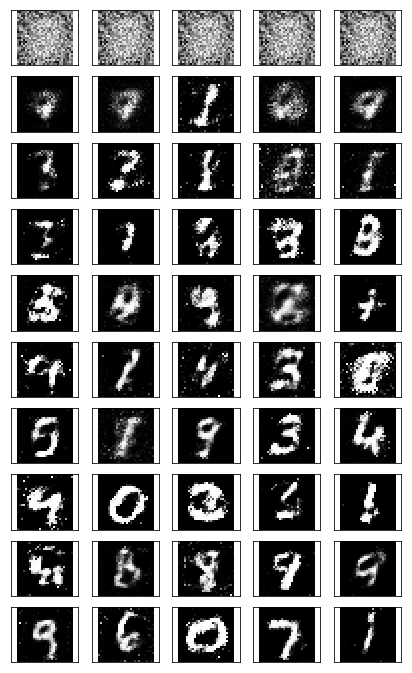

In [54]:
rows, cols = 10, 5
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)
print(np.shape(samples))
for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img, cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [56]:
fig.savefig('progress.png')